In [1]:
# Define a finite extent
# CENTER = -0.8 + 0.0j # Location of the extent center
# EXTENT = 3.0 + 3.0j # Extent length on the real axis
CENTER = -1.1195+0.2718j
EXTENT = 0.005+0.005j

# Select finite number of complex numbers
# In total width*height complex numbers will be inspected 
WIDTH = 1024  # number of elemtes along the real axis
HEIGHT = 1024 # number of elemtes along the imaginary axis

# Finite iterations
MAX_ITER = 1024 # Max number of iterations per

# Setting the baseline: Numba jit

In [4]:
import numpy as np
import numba

@numba.njit(nogil=True)
def mandelbrot(c, max_iter=MAX_ITER):
    z = 0

    # Per complex number, validate it for a finite number of iterations
    for k in range(max_iter):
        z = z**2 + c

        # if the modulus (or absolute value) of the complex number is greater than 2,
        # it will diverge, thus not within Mandelbrot set
        if np.absolute(z) > 2.0: 
            break

    return k

@numba.njit(nogil=True)
def compute_mandelbrot(width=WIDTH, height=HEIGHT, center=CENTER, extent=EXTENT, max_iter=MAX_ITER):
    niters = np.zeros((width, height), np.int64)
    scale = max(extent.real / width, extent.imag / height)

    # Loop through all selected complex number within the extent
    for h in range(height):
        for w in range(width):
            c = center + (w - width // 2 + (h - height // 2) * 1j) * scale
            k = mandelbrot(c, max_iter)
            niters[h, w] = k
    return niters

In [5]:
# Compute once to compile
niters = compute_mandelbrot()

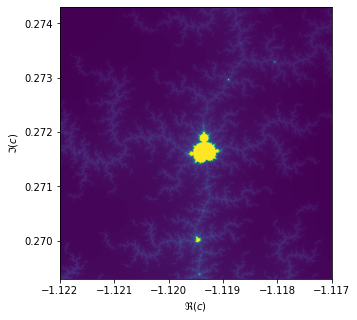

In [6]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(5,5))
c0, c1 = CENTER - EXTENT / 2, CENTER + EXTENT / 2
plot_extent = (c0.real, c1.real, c0.imag, c1.imag)

ax.imshow(niters, origin='lower', extent=plot_extent)
ax.set_xlabel("$\Re(c)$")
ax.set_ylabel("$\Im(c)$") ;

In [7]:
%%timeit
compute_mandelbrot()

507 ms ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Solution 1: Numba jit parallel
Numba has built-in parallelisation options. Let's try them!

In [8]:
@numba.njit(parallel=True)
def compute_mandelbrot_par(width=WIDTH, height=HEIGHT, center=CENTER, extent=EXTENT, max_iter=MAX_ITER):
    niters = np.zeros((width, height), np.int64)
    scale = max(extent.real / width, extent.imag / height)

    # Loop through all selected complex number within the extent
    for h in range(height):
        for w in range(width):
            c = center + (w - width // 2 + (h - height // 2) * 1j) * scale
            k = mandelbrot(c, max_iter)
            niters[h, w] = k
    return niters

In [9]:
# Compute once to compile
compute_mandelbrot_par() ;

In [10]:
%%timeit
compute_mandelbrot_par()

501 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


That is actually slower!

# Solution 2: Dask bag?

In [11]:
import dask.bag as db

@numba.njit(nogil=True)
def iterate_mandelbrot(coords, width, height, max_iter, center, extent):
    h, w = coords
    z = 0
    scale = max(extent.real/width, extent.imag/height)
    c = center + (w - width // 2 + (h - height // 2) * 1j) * scale
    
    # Per complex number, validate it for a finite number of iterations
    for k in range(max_iter):
        z = z**2 + c

        # if module (or absolute value) of the complex number greater than 2,
        # it will diverge, thus not within Mandelbrot set
        if np.absolute(z) > 2.0: 
            break
    return k

def compute_mandelbrot_dask(width=WIDTH, height=HEIGHT, max_iter=MAX_ITER, center=CENTER, extent=EXTENT):
    initial_state = np.ndindex(width, height)
    bag = db.from_sequence(initial_state, npartitions=16)
    return bag.map(lambda x: iterate_mandelbrot(x, width, height, max_iter, center, extent))

In [12]:
compute_mandelbrot_dask().compute(scheduler='threads');

In [10]:
#%%timeit
#compute_mandelbrot_dask().compute(scheduler='threads');

Ok, that is actually terrible. Can you think why?

# Solution 3: Numba vectorize

In [13]:
@numba.vectorize
def mandelbrot_vec(c, max_iter):
    z = 0

    # Per complex number, validate it for a finite number of iterations
    for k in range(MAX_ITER):
        z = z**2 + c

        # if the modulus (or absolute value) of the complex number is greater than 2,
        # it will diverge, thus not within Mandelbrot set
        if np.absolute(z) > 2.0: 
            break

    return k

In [14]:
def grid(width=WIDTH, height=HEIGHT, center=CENTER, extent=EXTENT):
    x0 = center - extent / 2
    x1 = center + extent / 2
    g = np.indices([height, width])
    scale = max(extent.real/width, extent.imag/height)
    return center + (g[1] - width // 2 + (g[0] - height // 2)*1j) \
                  * scale

In [15]:
mandelbrot_vec(grid(), MAX_ITER) ;

In [16]:
%%timeit
mandelbrot_vec(grid(), MAX_ITER)

510 ms ± 27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


That is on par with Numba jit on the outer loop.

# Solution 3b: Vectorize with dask.array

In [17]:
from dask import array as da

In [18]:
%%timeit
mandelbrot_vec(da.from_array(grid(), chunks=(64, 64)), MAX_ITER).compute()

122 ms ± 2.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


This is our first speedup!

# Solution 4: split boxes
We may split the domain ourselves. This requires a bit more structure to our code:

In [19]:
from dataclasses import dataclass
from dask import delayed

@delayed
def gather(*args):
    return list(args)

@dataclass
class Box:
    width: int
    height: int
    center: complex
    extent: complex
    
    def split(self, n):
        """Split the domain into nxn chunks. Returns a 2d list of `Box`."""
        sd = self.extent / n
        x0 = self.center - self.extent / 2 + sd / 2
        return [[Box(width=self.width//n, height=self.height//n,
                     center=x0 + w * sd.real + h * sd.imag * 1j,
                     extent=sd) for w in range(n)]
                for h in range(n)]
    
@delayed
def compute_mandelbrot_box(box, max_iter=MAX_ITER):
    return compute_mandelbrot(box.width, box.height, box.center, box.extent, max_iter)

def split_domain_map(box, f, n=4, num_workers=None):
    wf = gather(*[gather(*[f(sub_domain) for sub_domain in row])
                  for row in box.split(n)])
    return np.block(wf.compute(num_workers=num_workers))

In [20]:
%%timeit
split_domain_map(Box(WIDTH,HEIGHT,CENTER,EXTENT), compute_mandelbrot_box)

104 ms ± 9.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So this is a bit more work, but we get the best speed-up!